In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.io

import os

%matplotlib inline

## Part 1 - Neural Networks

### 1.1 Visualizing the data

In [2]:
# Read the data
FOLDER = 'data'
FILE = 'ex4data1.mat'
path = os.path.join(FOLDER, FILE)

data = scipy.io.loadmat(path)
X = pd.DataFrame(data = data['X'],
                 columns = ['x'+str(i) for i in range(data['X'].shape[1])])
Y = pd.Series(data = data['y'].flatten())
print("X is of dimensions {0}".format(X.shape))
print("y is of dimensions {0}".format(Y.shape))

X is of dimensions (5000, 400)
y is of dimensions (5000,)


True value = 4


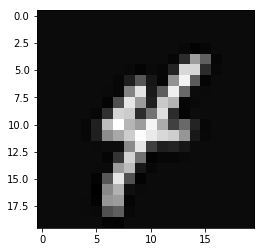

In [3]:
plt.gray()
row = 2007
plt.imshow(X.loc[row,:].values.reshape((20,20), order = 'F'), aspect = 'equal')
print("True value = {0}".format(Y[row].item()))

### 1.2 Model Representation

In [4]:
input_units = 400
hidden_units = 25
output_units = 10

# Read the weights provided
FILE = 'ex4weights.mat'
path = os.path.join(FOLDER, FILE)
weights = scipy.io.loadmat(path)
theta1_df = pd.DataFrame(data = weights["Theta1"],
                      columns = ['theta'+str(i) for i in range(weights["Theta1"].shape[1])])
theta2_df = pd.DataFrame(data = weights["Theta2"],
                      columns = ['theta'+str(i) for i in range(weights["Theta2"].shape[1])])

In [5]:
theta1_df.values.flatten()

array([-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
       -1.80365926e-06, -8.14464807e-06,  8.79454531e-09])

### 1.3 Feed forward and Cost function

The cost function for the neural network (without regularization) is $$ J(\theta)=\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left [ -y_k^{(i)} log ((h_{\theta}(x^{(i)}))_k) - (1-y_k^{(i)}) log(1-(h_{\theta}(x^{(i)}))_k) \right ] $$

In [6]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

def flat_param(t1_df, t2_df):
    # Flatten parameters to pass them to minimizer
    return np.concatenate([t1_df.values.flatten(),t2_df.values.flatten()], axis = 0)

def reshape_param(flat_params, input_size, hidden_size, output_size): #n_m, n_u, n_f
    # Return parameters to their original shapes
    t1 = flat_params[:int((input_size+1)*hidden_size)].reshape((hidden_size,input_size+1))
    t1_df = pd.DataFrame(data = t1,
                        columns = ['theta'+str(i) for i in range(t1.shape[1])])
    
    t2 = flat_params[int((input_size+1)*hidden_size):].reshape((output_size, hidden_size+1))
    t2_df = pd.DataFrame(data = t2,
                        columns = ['theta'+str(i) for i in range(t2.shape[1])])
       
    return t1_df, t2_df

def np_to_df(array):
    df = pd.DataFrame(data = array,
                     columns = [str(i+1) for i in range(array.shape[1])])
    return df

def nnCostFunction(params, input_layer_size, hidden_layer_size, num_labels, x, y):
    # Assumes the params have been flattened with order = 'C'
    
    # Split the params variable to corresponding theta variables and reshape the accordingly
    t1_df, t2_df = reshape_param(params, input_layer_size, hidden_layer_size, num_labels)
    
    # Store total number of examples
    m = x.shape[0]
    
    # Add the a_0 for the input layer
    a_inp = np.hstack((np.ones((x.shape[0],1)), x))
    
    # Calculate the dot product with the corresponding weights
    z_hid = np.dot(a_inp, t1_df.values.T)
    
    # Add the a_0 for the hidden layer and pass input layer through the sigmoid function
    a_hid = np.hstack((np.ones((z_hid.shape[0],1)), sigmoid(z_hid)))
    
    # Calculate the dot product with the corresponding weights
    z_out = np.dot(a_hid, t2_df.values.T)
    
    # Pass hidden layer through the sigmoid function
    a_out = sigmoid(z_out)
    
    # Create resulting dataframe
    a_out_df = np_to_df(a_out)
    
    # Create a (num_labels * num_of_training_examples) matrix to store the binary y classifications
    y_bin_df = np_to_df(np.zeros((m,num_labels)))

    for index, value in y.iteritems():
        y_bin_df.loc[index, str(value)] = 1
    
    # Calculate the cost for each column and each row in a dataframe
    cost = y_bin_df.multiply(np.log(a_out_df)) + (1-y_bin_df).multiply(np.log(1-a_out_df))
    
    total_cost = -cost.sum().sum() / m
    
    return total_cost, np_to_df(a_inp), np_to_df(z_hid), np_to_df(a_hid), np_to_df(z_out), a_out_df, y_bin_df

In [7]:
param_long = flat_param(theta1_df, theta2_df)
cost_example = nnCostFunction(param_long,
                              input_units,
                              hidden_units,
                              output_units,
                              X,
                              Y)[0]

print('The cost for the loaded set of parameters is {0}'.format(round(cost_example, 6)))

The cost for the loaded set of parameters is 0.287629


### 1.4 Regularized cost function

The cost for Neural Networks with regularization is given by $$ J(\theta)=\frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left [ -y_k^{(i)} log ((h_{\theta}(x^{(i)}))_k) - (1-y_k^{(i)}) log(1-(h_{\theta}(x^{(i)}))_k) \right ] + \frac{\lambda}{2m} \left [ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \right ] $$

In [8]:
# Enhancing the previously defined cost function

def nnCostFunctionReg(params, input_layer_size, hidden_layer_size, num_labels, x, y, l):
    # First term is the same as unregularized cost function   
    unreg_term, a_inp_df, z_hid_df, a_hid_df, z_out_df, a_out_df, y_bin_df = nnCostFunction(params,
                                                                        input_layer_size,
                                                                        hidden_layer_size,
                                                                        num_labels,
                                                                        x,
                                                                        y)
    
      
    # Reshape the thetas out of params
    t1_df, t2_df = reshape_param(params, input_layer_size, hidden_layer_size, num_labels)
    
    # Add regularization term
    reg_term = 0.5*l*(np.power(t1_df.iloc[:,1:],2).sum().sum() + np.power(t2_df.iloc[:,1:],2).sum().sum()) / x.shape[0]
    
    return unreg_term + reg_term, a_inp_df, z_hid_df, a_hid_df, z_out_df, a_out_df, y_bin_df

In [9]:
cost_example_reg = nnCostFunctionReg(param_long, input_units, hidden_units, output_units, X, Y, 1)[0]
print('The regularized cost for the loaded set of parameters is {0}'.format(round(cost_example_reg,6)))

The regularized cost for the loaded set of parameters is 0.38377


## Part 2 - Backpropagation

### 2.1 Sigmoid gradient

The gradient for the sigmoid function can be computed as $$ g'(z) = \frac{d}{dz} g(z) = g(z)(1-g(z)) $$ where $$ sigmoid(z) = g(z) = \frac{1}{1+e^{-z}} $$

In [10]:
def sigmoidGrad(z):
    return sigmoid(z)*(1-sigmoid(z))

In [11]:
test_val = 0
print('Calculated gradient when z = 0 is : {0}'.format(sigmoidGrad(test_val))) # Expected value for 0: 0.25

Calculated gradient when z = 0 is : 0.25


### 2.2 Random Initialization

In [12]:
def randInitializeWeights(L_in, L_out):
    e_init = 0.12
    return np.random.uniform(low = -e_init, high = e_init, size = (L_out, L_in + 1))

### 2.3 Backpropagation

In [13]:
def backProp(params, input_layer_size, hidden_layer_size, num_labels, x, y, l=0):
    # Feed forward step
    cost, a_inp_df, z_hid_df, a_hid_df, z_out_df, a_out_df, y_bin_df = nnCostFunctionReg(params,
                                                                                         input_layer_size,
                                                                                         hidden_layer_size,
                                                                                         num_labels,
                                                                                         x,
                                                                                         y,
                                                                                         l)

    # Count the number of examples
    m = x.shape[0]
    
    # Calculate delta for the output layer
    delta_out = a_out_df - y_bin_df # (5000,10)
    
    # Reshape the thetas out of params
    t1_df, t2_df = reshape_param(params, input_layer_size, hidden_layer_size, num_labels) # (25,401),(10,26)
    
    # Calculate delta for the hidden layer
    delta_hid = np.multiply(delta_out.dot(t2_df.iloc[:,1:].values), sigmoidGrad(z_hid_df)) # (5000,25)
    
    # Calculate the gradient for hidden layer
    grad_2 = np_to_df(np.dot(delta_out.T, a_hid_df)) / m # (10,26)
    
    # Calculate the gradient for input layer
    grad_1 = np_to_df(np.dot(delta_hid.T, a_inp_df)) / m # (25,401)
    
    return flat_param(grad_1, grad_2)

### 2.4 Gradient Checking

In [14]:
def checkNNgrad(a, lam = 0):
    input_size = 3
    hidden_size = 5
    labels = 3
    m = 10
    e = 1e-5
    
    w1_test = np_to_df(randInitializeWeights(input_size, hidden_size))
    w2_test = np_to_df(randInitializeWeights(hidden_size, labels))
    
    x = np_to_df(randInitializeWeights(input_size - 1, m))
    y = pd.Series(1 + np.mod(range(m), labels))
    
    nn_params = flat_param(w1_test, w2_test)

    w_diff = np.zeros(len(nn_params))
    w_diff[a] += e

    # Calculate the difference in cost function
    cost_diff = (nnCostFunctionReg(nn_params+w_diff, input_size, hidden_size, labels, x, y, lam)[0] \
              - nnCostFunctionReg(nn_params-w_diff, input_size, hidden_size, labels, x, y, lam)[0]) \
              / (2*e)
    
    # Calculate the gradients
    grads = backProp(nn_params, input_size, hidden_size, labels, x, y)
    grad1, grad2 = reshape_param(grads, input_size, hidden_size, labels)
    
    return cost_diff, grad1, grad2

In [15]:
# In the test function we have input_size = 3, hidden_size = 5 and labels = 3, therefore the total number of
# elements of flattened gradients will be [hidden_size * (input_size+1)] + [labels * (hidden_size + 1)] = 38
a = np.random.choice(range(38))
cost_diff, grad1, grad2 = checkNNgrad(a, lam = 0)
grads = flat_param(grad1, grad2)
print('The cost difference for position {1} is {0}'.format(round(cost_diff,8), a))
print('The gradient for position {1} is {0}'.format(round(grads[a],8), a))

The cost difference for position 37 is 0.1119469
The gradient for position 37 is 0.1119469


### 2.5 Regularized Neural Network

After implementing the backpropagation algorithm, we need to add regularization to the gradient: 
\begin{align*} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \text{for j = 0} \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \text{for j $\geq$ 1} \\
\end{align*}

In [16]:
def backPropReg(params, input_layer_size, hidden_layer_size, num_labels, x, y, l):
    # Count the number of examples
    m = x.shape[0]    
    
    # Get the unregularized gradients
    grads = backProp(params, input_layer_size, hidden_layer_size, num_labels, x, y)
    grad_1, grad_2 = reshape_param(grads, input_layer_size, hidden_layer_size, num_labels)
    
    # Reshape the thetas out of params
    t1_df, t2_df = reshape_param(params, input_layer_size, hidden_layer_size, num_labels)
    
    # Regularize the gradients, leaving out the "bias" column (the first one)
    grad_1.iloc[:,1:] += l * t1_df.iloc[:,1:].values / m
    grad_2.iloc[:,1:] += l * t2_df.iloc[:,1:].values / m
    
    return flat_param(grad_1, grad_2)

Perform gradient checking again for the regularized gradients

In [17]:
def checkNNgradReg(a, lam = 0):
    input_size = 3
    hidden_size = 5
    labels = 3
    m = 10
    e = 1e-5
    
    w1_test = np_to_df(randInitializeWeights(input_size, hidden_size))
    w2_test = np_to_df(randInitializeWeights(hidden_size, labels))
    
    x = np_to_df(randInitializeWeights(input_size - 1, m))
    y = pd.Series(1 + np.mod(range(m), labels))
    
    nn_params = flat_param(w1_test, w2_test)

    w_diff = np.zeros(len(nn_params))
    w_diff[a] += e

    # Calculate the difference in cost function
    cost_diff = (nnCostFunctionReg(nn_params+w_diff, input_size, hidden_size, labels, x, y, lam)[0] \
              - nnCostFunctionReg(nn_params-w_diff, input_size, hidden_size, labels, x, y, lam)[0]) \
              / (2*e)
    
    # Calculate the gradients
    grads = backPropReg(nn_params, input_size, hidden_size, labels, x, y, lam)
    grad1, grad2 = reshape_param(grads, input_size, hidden_size, labels)
    
    return cost_diff, grad1, grad2

In [18]:
# In the test function we have input_size = 3, hidden_size = 5 and labels = 3, therefore the total number of
# elements of flattened gradients will be [hidden_size * (input_size+1)] + [labels * (hidden_size + 1)] = 38
a = np.random.choice(range(38))
cost_diff, grad1, grad2 = checkNNgradReg(a, lam = 3)
grads = flat_param(grad1, grad2)
print('The regularized cost difference for position {1} is {0}'.format(round(cost_diff,8), a))
print('The regularized gradient for position {1} is {0}'.format(round(grads[a],8), a))

The regularized cost difference for position 15 is -0.02454097
The regularized gradient for position 15 is -0.02454097


### Learning parameters using fmincg

In [19]:
# Create a wrapper function to return only the cost, in order to make the minimizer work
def nnCostFunctionReg_onlyCost(params, input_layer_size, hidden_layer_size, num_labels, x, y, l):
    return nnCostFunctionReg(params, input_layer_size, hidden_layer_size, num_labels, x, y, l)[0]

In [20]:
# Regularization parameter of 5 is used
mylambda = 5.
params = flat_param(theta1_df, theta2_df)
input_units = 400
hidden_units = 25
output_units = 10

# Training the model with fmin_cg
result = opt.fmin_cg(nnCostFunctionReg_onlyCost,
                     x0=params,
                     fprime=backPropReg,
                     args=(input_units, hidden_units, output_units, X, Y, mylambda),
                     maxiter=100,
                     disp=True,
                     full_output=True)

theta1_opt, theta2_opt = reshape_param(result[0], input_units, hidden_units, output_units)

         Current function value: 0.725847
         Iterations: 100
         Function evaluations: 207
         Gradient evaluations: 207


In [21]:
def nnPreds(params, input_layer_size, hidden_layer_size, num_labels, x, y):
    # Assumes the params have been flattened with order = 'C'
    
    # Split the params variable to corresponding theta variables and reshape the accordingly
    t1_df, t2_df = reshape_param(params, input_layer_size, hidden_layer_size, num_labels)
    
    # Store total number of examples
    m = x.shape[0]
    
    # Add the a_0 for the input layer
    a_inp = np.hstack((np.ones((x.shape[0],1)), x))
    
    # Calculate the dot product with the corresponding weights
    z_hid = np.dot(a_inp, t1_df.values.T)
    
    # Add the a_0 for the hidden layer and pass input layer through the sigmoid function
    a_hid = np.hstack((np.ones((z_hid.shape[0],1)), sigmoid(z_hid)))
    
    # Calculate the dot product with the corresponding weights
    z_out = np.dot(a_hid, t2_df.values.T)
    
    # Pass hidden layer through the sigmoid function
    a_out = sigmoid(z_out)
    
    # Create resulting dataframe
    a_out_df = np_to_df(a_out)
    
    # Predict the label with the maximum score
    #preds = a_out_df.apply(lambda x: x.argmax(), axis=1)
    preds = a_out_df.idxmax(axis=1).astype(int)
    
    return preds

In [22]:
predictions = nnPreds(result[0], input_units, hidden_units, output_units, X, Y)
accuracy = (predictions == Y).mean()
print('Algorithm correctly classifies {0}% of the examples'.format(round(accuracy*100,2)))

Algorithm correctly classifies 96.16% of the examples


## Part 3 - Visualizing the hidden layer

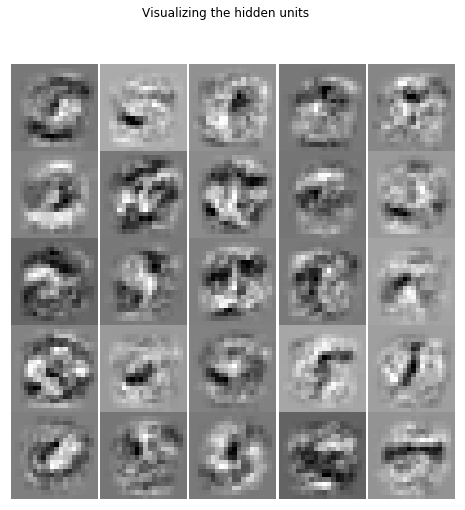

In [23]:
images = 25
cols = 5
fig = plt.figure(figsize = (8,8))

for i in range(images):
    a = fig.add_subplot(cols, np.ceil(images/float(cols)), i + 1)
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.grid(False)
    a.axis('off')
    plt.imshow(theta1_opt.iloc[i,1:].values.reshape(20,20).T,
               cmap='gray',
               interpolation='none')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Visualizing the hidden units')
plt.show()